# Determining Student Knowledge Status

### Introduction

Understanding how student study methods and examination results affect the retention of information is essential to create better teaching and learning methodologies. At a university in Turkey, Ph.D students collected data on undergraduate students' understanding of Electrical DC Machines. They utilized five standardized characteristics to determine the knowledge level of students from very low to high. The five variables included the amount of study time, number of repetitions and exam performance for goal object materials as well as the amount of study time and exam performance for related objects with the goal object.

Through this project, we propose to answer the following question: 

> *Given the degree of preparation and examination results of a student, what will be the knowledge retention level of said student?* 

We aim to achieve this by training a model that, given the five aforementioned characteristics, will classify the knowledge level of a student. 

### Preliminary Exploratory Data Analysis

In [29]:
## Run this cell before continuing
library(tidyverse)
library(readxl)
library(repr)

The dataset we will be using is the **User Knowledge Modeling Data Set** provided by the *UCI Machine Learning Repository*, linked [here](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

This dataset has the following variables:
- `STG`: The degree of study time for goal object materials
- `SCG`: The degree of repetition number of user for goal object materials
- `STR`: The degree of study time of user for related objects with goal object
- `LPR`: The exam performance of user for related objects with goal object
- `PEG`: The exam performance of user for goal objects
- `UNS`: The knowledge level of user

Utilizing the first five variables, we aim to predict the sixth variable, `UNS`, which is a student's knowledge level. The knowledge level variable has one of four possible labels: `High`, `Middle`, `Low` and `Very Low`.

First, let's read in the training data:

In [30]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, destfile = "data/Data_User_Modeling_Dataset.xls")
knowledge <- read_excel("data/Data_User_Modeling_Dataset.xls", sheet = 2) %>%
    select(STG:UNS)

head(knowledge, n = 5)

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


Note that the first five variables appear to be normalized to be in the range [0, 1]. This will actually make things easier for us when training our classification model!

Additionaly, note that out of all category names, only `STG` and `STR` properly communicate what they represent. Let's change the variable names to the following, which better communicate what they represent:
- `STG`: Study Time degree for Goal object materials
- `RNG`: Repetition Number degree for Goal object materials
- `STR`: Study Time degree for Related objects with goal object materials
- `EPR`: Exam Performance for Related objects with goal objects
- `EPG`: Exam Performance for Goal object
- `SKL`: Student Knowledge Level

In [31]:
knowledge <- knowledge %>%
    rename(RNG = SCG,
           EPR = LPR, 
           EPG = PEG,
           SKL = UNS)
head(knowledge, n = 5)

STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


That's better. Let's continue tidying up the data!

Now, the wide format in which this data is currently represented is not exactly tidy. For one thing, how does one know what the numbers represent? Without contextual knowledge, this format makes it impossible to know. To solve this problem, we reshape the data set to a tidy data format by creating a column called "predictor_type" and a column called “performance.”

In [32]:
knowledge <- knowledge %>%
    pivot_longer(cols = STG:EPG,
                 names_to = 'predictor_type',
                 values_to = 'performance')

In [33]:
head(knowledge, n = 10)

SKL,predictor_type,performance
<chr>,<chr>,<dbl>
very_low,STG,0.00
very_low,RNG,0.00
very_low,STR,0.00
very_low,EPR,0.00
very_low,EPG,0.00
High,STG,0.08
High,RNG,0.08
High,STR,0.10
High,EPR,0.24


The data above appears to be in tidy format. That is, each row is a single observation, each column is a single variable and each cell contains a single value.

A few changes, however, will make this data easier to work with:
- Firstly, transform all knowledge level (SKL) labels to lower case
- Then transform the knowledge level (SKL) column to be a factor column instead of the current character column.

In [34]:
knowledge <- knowledge %>%
    mutate(SKL = as_factor(tolower(SKL)))
head(knowledge, n=10)

SKL,predictor_type,performance
<fct>,<chr>,<dbl>
very_low,STG,0.00
very_low,RNG,0.00
very_low,STR,0.00
very_low,EPR,0.00
very_low,EPG,0.00
high,STG,0.08
high,RNG,0.08
high,STR,0.10
high,EPR,0.24


There, that's more like it.

Now let's summarize the data to gain some more insight. To do this, we create a table that:
1. reports the number of observations in each class of knowledge
2. reports the mean performance for each class 
3. reports the number of rows that have missing data for each class

In [35]:
summary_table <- knowledge %>%
    group_by(SKL) %>%
    summarize(class_count = n(), avg_performance = mean(performance), missing_rows = sum(is.na(SKL))) %>%
    arrange(avg_performance)
summary_table

`summarise()` ungrouping output (override with `.groups` argument)



SKL,class_count,avg_performance,missing_rows
<fct>,<int>,<dbl>,<int>
very_low,120,0.2639500,0
low,415,0.3647687,0
middle,440,0.4319886,0
high,315,0.5240635,0


Wonderful! It appears that our target variable contains no missing values.

Additionally, we see an interesting relationship between the `avg_performance` and `SKL` variables. It appears that there exists a positive relationship between the two. To confirm or disprove this hypothesis, we can visualize the data as follows.

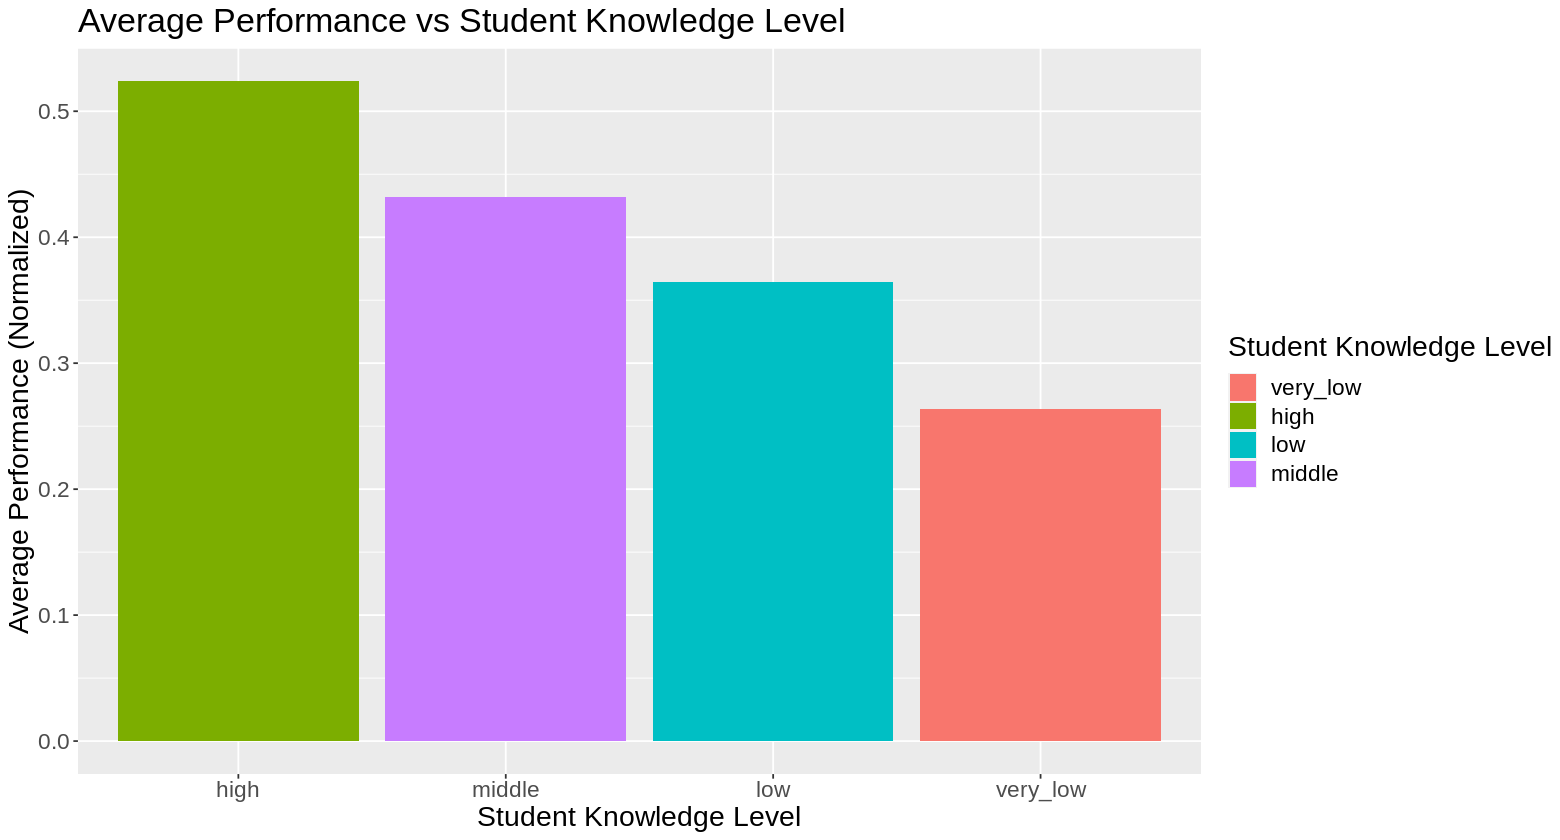

In [36]:
options(repr.plot.width = 13, repr.plot.height = 7)

summary_table %>%
    ggplot(aes(x = reorder(SKL, -avg_performance), y = avg_performance, fill = SKL)) + 
    geom_bar(stat = 'identity') + 
    labs(x = 'Student Knowledge Level', y = 'Average Performance (Normalized)', fill = 'Student Knowledge Level') + 
    ggtitle('Average Performance vs Student Knowledge Level') + 
    theme(text = element_text(size = 17))

Hypothesis confirmed! This will be an interesting relationship to further evaluate.

### Methods

As mentioned above, will be using five variables to perform our data analysis and predict the specific knowledge level of a given student observation: 
1. degree of study time for goal object materials
2. degree of repetition number for goal object materials
3. degree of study time for related goal objects
4. exam performance for goal object materials, and
5. exam performance for related goal objects

Since the data is normalized and there are no null values present, we will include every observation in our dataset.

To better communicate our results, we will be including several visualizations. One, for example, will be a scatterplot of a combination of variables (1), (2), and (3) on the (named total preparation) y-axis, and a combination of variables (4) and (5) on the x-axis (total examination results). Each point will be *colored according to the user’s knowledge level*. This will enable us to deduce two pieces of information. Firstly, we will be able to deduce if a relationship exists between the *degree of studying* and *exam performance*. Additionally, and what is potentially a more significant finding, we will be able to deduce whether a relationship exists between *student preparation and exam performance* and *student knowledge level*.


### Expected outcomes and significance

Through our data analysis, we expect to find that specific levels of preparedness and examination results are associated with certain levels of knowledge. This study will have major implications in the academic community. By understanding how preparedness variables affect knowledge retention, students can develop and implement better learning strategies that will improve their knowledge retention. For further research, determining which of the five variables has the largest implication on knowledge status would be advantageous, enabling students to focus on the factors that most affect knowledge retention.